### GOAL: Recreate Figure 7 from the GWTC-3 paper using numpy, pandas, matplotlib, and seaborn.

#### 0.1. Set Up

In [1]:
import h5py  # lets you store huge amounts of numerical data, and easily manipulate that data from NumPy.
from os import listdir
"""
os模块提供的就是各种 Python 程序与操作系统进行交互的接口。通过使用os模块，一方面可以方便地与操作系统进行交互，另一方面页可以极大增强代码的可移植性。
如果该模块中相关功能出错，会抛出OSError异常或其子类异常。

os.listdir() method in python is used to get the list of all files and directories in the specified directory. If we don’t specify any directory,
then list of files and directories in the current working directory will be returned.
"""
from os.path import join
"""
os.path  This module implements some useful functions on pathnames. 
os.path.join  Join one or more path segments intelligently. 
"""
from fnmatch import fnmatch  # This module provides support for Unix shell-style wildcards, which are not the same as regular expressions
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#### 1.1. Data Preparation

In [2]:
# 给出文件的绝对路径
address = 'E:\\Docker_Projects\\GWTC-3\\'

# 将文件取出并将event的名字拆出来
event_file = [ ]
for file in listdir(address):
    if fnmatch(file, 'IGWN-GWTC3p0-v2-*_cosmo.h5'):
        event_file.append((file.split('_PEDataRelease')[0].split('-')[3], file))

# 要绘制的五个参数
vars = ['chirp_mass_source', 'mass_ratio', 'chi_eff', 'chi_p', 'luminosity_distance']

# 取出先验跟后验样本
df_list = []
for vi, (ename, file_name) in enumerate(event_file):

    with h5py.File(join(address, file_name), 'r') as f:   
        # 先验样本
        priors = pd.DataFrame(dict(f['C01:IMRPhenomXPHM'
                                    if ename not in ['GW191219_163120', 'GW200105_162426', 'GW200115_042309'] #'GW200105_162426'这个样本没有'C01:IMRPhenomXPHM:HighSpin'列啊？？？？？
                                    else 'C01:IMRPhenomXPHM:HighSpin']['priors']['samples']))
        #后验样本
        posterior_samples = pd.DataFrame(f['C01:Mixed']['posterior_samples'][:])

    # 给先验样本打标签bottom，后验样本打标签upper，以便分组
    df = pd.DataFrame({
        **{ 
            var: np.log10(posterior_samples[var] / (1000 if var=='luminosity_distance' else 1))
            if 'mass' in var or 'distance' in var
            else posterior_samples[var] for var in vars
        },
        'violin': 'upper',
        'event': ename,
    })
    df_list.append(df)
    
    df_prior = pd.DataFrame({
        **{
            var: np.log10(priors[var] / (1000 if var=='luminosity_distance' else 1))
            if 'mass' in var or 'distance' in var
            else priors[var] for var in vars
        },
        'violin': 'bottom',
        'event': ename,
    })
    df_list.append(df_prior)

# 将先验跟后验数据合并
data = pd.concat(df_list)

#### 1.2. Plot for chirp_mass_source, mass_ratio, chi_eff, chi_p and luminosity_distance of events

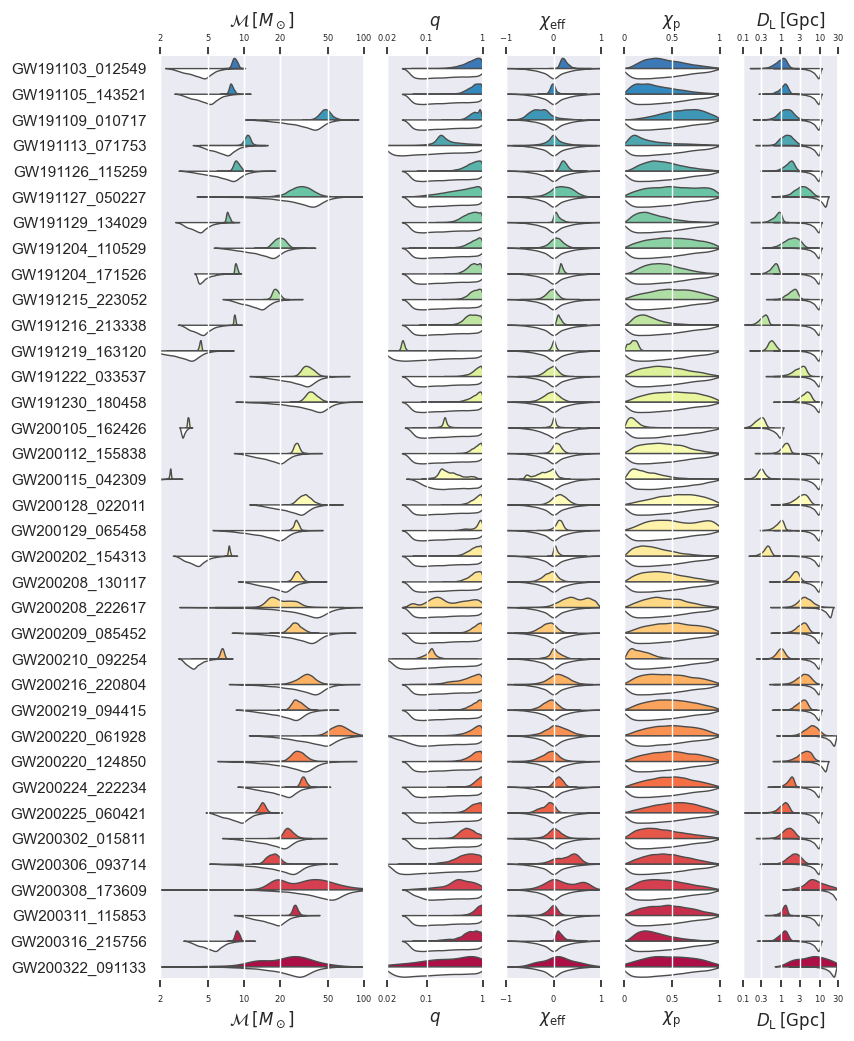

In [25]:
# 使用seaabron默认风格
sns.set()

# 事先给定画布跟坐标图的属性
fig, ax = plt.subplots(1, len(vars), figsize=(8.75,12), sharey=False,
                      gridspec_kw = {'wspace':0.2, 'width_ratios':[1.5, 0.7, 0.7, 0.7, 0.7]})

# 准备绘图的x取值范围
xlim = [2, 100, 0.02, 1, -1, 1, 0, 1, 0.1, 30]

# 为画刻度做准备
tick_map = {
    'chirp_mass_source':[2,5,10,20,50,100],
    'mass_ratio': [0.02, 0.1, 1],
    'chi_eff': [-1,0,1],
    'chi_p': [0, 0.5, 1],
    'luminosity_distance': [0.1,0.3,1,3,10,30]
}

# 为每个坐标图的x轴标签做准备
column_name2tex_name = {
        'chirp_mass_source':r'\mathcal{{M}}\:[M_\odot]',
        'mass_ratio':r'q',
        'chi_eff':r'\chi_{{\rm eff}}',
        'chi_p':r'\chi_{{\rm p}}',
        'luminosity_distance':r'D_{\rm L}\:[{\rm Gpc}]',
}

# 获取颜色参数
colors = sns.color_palette("Spectral_r", len(event_file)+2).as_hex()[2:38]

# 画图
for vi, var in enumerate(vars):
    sns_axi = sns.violinplot(data, x=var, y='event', hue='violin',
                             orient="h", density_norm='width', inner=None, split=True, legend=False,
                             ax=ax[vi],
                             linewidth=1
                            )

    violin_pairs = []
    for v, violin_half in enumerate(sns_axi.get_children()):
        if v % 2 == 0: # Upper violin
            violin_pairs.append([])
        violin_pairs[-1].append(violin_half)
    # 给每个 event 指定颜色
    for pair, (ev, _), col in zip(violin_pairs, event_file, colors):
        pair[0].set_facecolor(col)        # 为 posterior 指定颜色
        pair[1].set_facecolor('#FFFFFF')  # 为 prior 白色
        
    # set x labels
    ax[vi].set_xlabel(r'$'+column_name2tex_name[var]+r'$', fontsize=12)
    # set top x label
    ax_copy = ax[vi].twiny()
    ax_copy.set_xlabel(r'$'+column_name2tex_name[var]+r'$', fontsize=12)
    
    # 设定坐标的边界
    if 'mass' in var or 'distance' in var:
        ax[vi].set_xlim(np.log10(xlim[2*vi:2*vi+2]))
        ax_copy.set_xlim(np.log10(xlim[2*vi:2*vi+2]))
    else:
        ax[vi].set_xlim(xlim[2*vi:2*vi+2])
        ax_copy.set_xlim(xlim[2*vi:2*vi+2])

    # 删掉 `events`        
    ax[vi].set_ylabel('')
    if vi:    
        ax[vi].yaxis.set_visible(False)

    # set tick labels
    if 'mass' in var or 'distance' in var:
        ax[vi].set_xticks(np.log10(tick_map[var]))
        ax_copy.set_xticks(np.log10(tick_map[var]))
        sns_axi.set_xticklabels([f'${lab}$' for lab in tick_map[var]], fontsize=6)
        ax_copy.set_xticklabels([f'${lab}$' for lab in tick_map[var]], fontsize=6)
    else:
        sns_axi.set_xticks(tick_map[var])
        ax_copy.set_xticks(tick_map[var])
        sns_axi.set_xticklabels([f'${lab}$' for lab in tick_map[var]], fontsize=6)
        ax_copy.set_xticklabels([f'${lab}$' for lab in tick_map[var]], fontsize=6)

#### 2.1. Comparing

In [5]:
from IPython.display import IFrame
IFrame('screenshot_fig7_GWTC3.pdf', width=800, height=1200)